# ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

In [2]:
import warnings
warnings.filterwarnings('ignore')

Ключевые вопросы:

1. Выяснить, какие факторы влияют на зарплату специалиста **Data Scientist**.
1. А также ответить на ключевые вопросы HR-агентства:
   * Наблюдается ли ежегодный рост зарплат у специалистов **Data Scientist**?
   * Как соотносятся зарплаты **Data Scientist** и **Data Engineer** в 2022 году?
   * Как соотносятся зарплаты специалистов **Data Scientist** в компаниях различных размеров?
   * Есть ли связь между наличием должностей **Data Scientist** и **Data Engineer** и размером компании?

## Ввод данных

In [3]:
import pandas as pd

hr_df = pd.read_csv("data\\data.zip").drop("Unnamed: 0", axis=1)

## Знакомство с данными

* `work_year` - Год, в котором была выплачена зарплата.
* `experience_level` - Опыт работы на этой должности в течение года со следующими возможными значениями:
   * EN — Entry-level/Junior;
   * MI — Mid-level/Intermediate;
   * SE — Senior-level/Expert;
   * EX — Executive-level/Director.
* `employment_type` - Тип трудоустройства для этой роли:
   * PT — неполный рабочий день;
   * FT — полный рабочий день;
   * CT — контракт;
   * FL — фриланс.
* `job_title` - Роль, в которой соискатель работал в течение года.
* `salary` - Общая выплаченная валовая сумма заработной платы.
* `salary_currency` - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* `salary_in_usd` - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* `employee_residence` - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* `remote_ratio` - Общий объём работы, выполняемой удалённо. Возможные значения:
   * 0 — удалённой работы нет (менее 20 %);
   * 50 — частично удалённая работа;
   * 100 — полностью удалённая работа (более 80 %).
* `company_location` - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* `company_size` - Среднее количество людей, работавших в компании в течение года:
   * S — менее 50 сотрудников (небольшая компания);
   * M — от 50 до 250 сотрудников (средняя компания);
   * L — более 250 сотрудников (крупная компания).

In [4]:
hr_df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [5]:
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 52.3+ KB


Всего 607 записей, пропусков нет

## Поиск дубликатов

In [6]:
print("Количество дубликатов: {}".format(hr_df.duplicated().sum()))

Количество дубликатов: 42


In [7]:
hr_df = hr_df.drop_duplicates()
print("Количество строк после очистки от дубликатов: {}".format(hr_df.shape[0]))

Количество строк после очистки от дубликатов: 565


## Свойства данных

In [8]:
hr_df.describe(include="object")

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,565,565,565,565,565,565,565
unique,4,4,50,17,57,50,3
top,SE,FT,Data Scientist,USD,US,US,M
freq,243,546,130,359,295,318,290


In [9]:
pd.set_option('display.float_format', lambda x: '%.8g' % x)
hr_df.select_dtypes(include="int64").describe()

,work_year,salary,salary_in_usd,remote_ratio
count,565,565,565,565
mean,2021.3646,338115.99,110610.34,69.911504
std,0.6981384,1599878.8,72280.703,40.900666
min,2020,4000,2859,0
25%,2021,67000,60757,50
50%,2021,110925,100000,100
75%,2022,165000,150000,100
max,2022,30400000,600000,100


## Преобразование признаков

У нас имеются упорядоченные категориальные признаки:

* experience_level
* remote_ratio
* company_size

Преобразуем их в соответствии с таблицей:

| ПРИЗНАК | ЗНАЧЕНИЯ ПРИЗНАКА | ЗНАЧЕНИЯ ПРИЗНАКА ПОСЛЕ ПРЕОБРАЗОВАНИЯ |
| :---: | :---: | :---: |
| experience_level | EN, MI, SE, EX | 1, 2, 3, 4 |
| remote_ratio | 0, 50, 100 | 0, 1, 2 |
| company_size | S, M, L | 1, 2, 3 |

### Применение изменений

In [10]:
replace_dict = {
    "experience_level" : (["EN","MI","SE","EX"],[1, 2, 3, 4]),
    "remote_ratio" : ([0, 50, 100],[0, 1, 2]),
    "company_size": (["S","M","L"],[1, 2, 3])
}

for col in replace_dict:
    hr_df[col] = hr_df[col].replace(replace_dict[col][0], replace_dict[col][1])

hr_df.describe()

,work_year,experience_level,salary,salary_in_usd,remote_ratio,company_size
count,565,565,565,565,565,565
mean,2021.3646,2.3663717,338115.99,110610.34,1.3982301,2.1964602
std,0.6981384,0.79800401,1599878.8,72280.703,0.81801332,0.67001762
min,2020,1,4000,2859,0,1
25%,2021,2,67000,60757,1,2
50%,2021,2,110925,100000,2,2
75%,2022,3,165000,150000,2,3
max,2022,4,30400000,600000,2,3


###
___

Так же имеются номинальные категориальные признаки:

* employment_type

Закодируем признак employment_type. Используем класс `OneHotEncoding` библиотеки *category_encoders*.

In [11]:
import category_encoders as ce

encoder = ce.OneHotEncoder(cols=['employment_type'], use_cat_names=True)
type_bin = encoder.fit_transform(hr_df['employment_type'])
hr_df = pd.concat([hr_df, type_bin], axis=1)

Посмотрим на результат

In [12]:
hr_df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,employment_type_FT,employment_type_CT,employment_type_PT,employment_type_FL
0,2020,2,FT,Data Scientist,70000,EUR,79833,DE,0,DE,3,1,0,0,0
1,2020,3,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,1,1,0,0,0
2,2020,3,FT,Big Data Engineer,85000,GBP,109024,GB,1,GB,2,1,0,0,0
3,2020,2,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,1,1,0,0,0
4,2020,3,FT,Machine Learning Engineer,150000,USD,150000,US,1,US,3,1,0,0,0


## Отбор признаков

Сперва удалим уже не нужный признак `employment_type`. \
Далее удалим признаки `salary` и `salary_currency` так как информация о зарплате присутствует в едином формате в колонке `salary_in_usd`

In [13]:
columns = ["employment_type", "salary", "salary_currency"]

hr_df = hr_df.drop(columns=columns, axis=1)
hr_df.head()

,work_year,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,employment_type_FT,employment_type_CT,employment_type_PT,employment_type_FL
0,2020,2,Data Scientist,79833,DE,0,DE,3,1,0,0,0
1,2020,3,Machine Learning Scientist,260000,JP,0,JP,1,1,0,0,0
2,2020,3,Big Data Engineer,109024,GB,1,GB,2,1,0,0,0
3,2020,2,Product Data Analyst,20000,HN,0,HN,1,1,0,0,0
4,2020,3,Machine Learning Engineer,150000,US,1,US,3,1,0,0,0


# Анализ данных

Для просмотра зависимости зарплаты Data Scientist проведем графический анализ

### Скопируем исходный датафрейм:

In [14]:
df_copy = hr_df.copy()

Отфильтруем его, чтобы у нас была статистика только по профессии Data Scientist

In [15]:
df_copy = df_copy[df_copy["job_title"] == "Data Scientist"]
df_copy = df_copy.drop(columns=["job_title"], axis=1)

In [16]:
df_copy.head()

,work_year,experience_level,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,employment_type_FT,employment_type_CT,employment_type_PT,employment_type_FL
0,2020,2,79833,DE,0,DE,3,1,0,0,0
7,2020,2,35735,HU,1,HU,3,1,0,0,0
10,2020,1,51321,FR,0,FR,1,1,0,0,0
11,2020,2,40481,IN,0,IN,3,1,0,0,0
12,2020,1,39916,FR,0,FR,2,1,0,0,0


### Распределение заработной платы среди специалистов Data Scientist

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

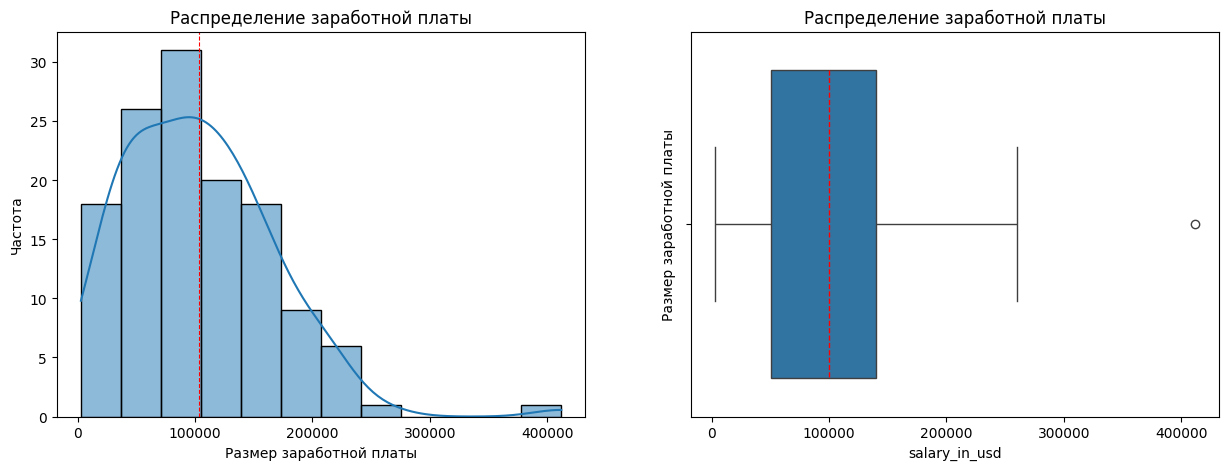

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df_copy['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы', ylabel='Частота')
axes[0].set_title('Распределение заработной платы')
axes[0].axvline(df_copy['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(df_copy['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы')
axes[1].set_title('Распределение заработной платы');

Судя по графикам, специалисты в сфере Data Scientist в среднем зарабатывают 100тыс. С отклонением $\pm$ 50тыс. \
Прослеживается нормальное распределение зарплат, но левостороннее. \
Присутствует выброс в размере около 400тыс.

### Распределение заработной платы по годам

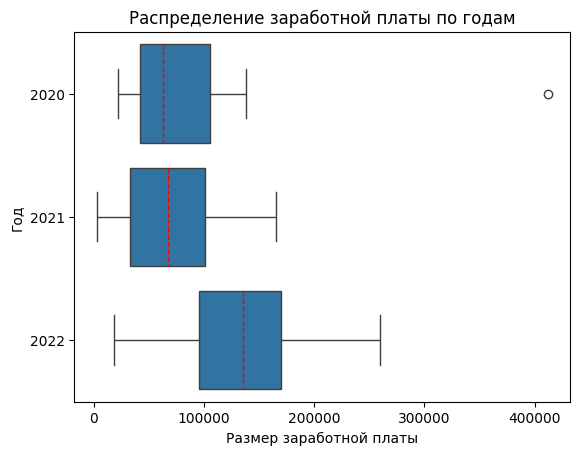

In [19]:
ax = sns.boxplot(df_copy, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработной платы', ylabel='Год')
plt.title('Распределение заработной платы по годам')
plt.show()

Исходя из полученного графика, можно сделать вывод, что с каждым годом зарплата Data Scientist специалиста растет:

* 2020: медианная зарплата - 80 тыс.
* 2021: медианная зарплата - 90 тыс.
* 2022: медианная зарплата - 140 тыс.

Выброс в 400 тыс. присутствует в 2020 году

Данное утверждение необходимо проверить с помощью статистических тестов

### Распределение заработной платы по уровню специалиста

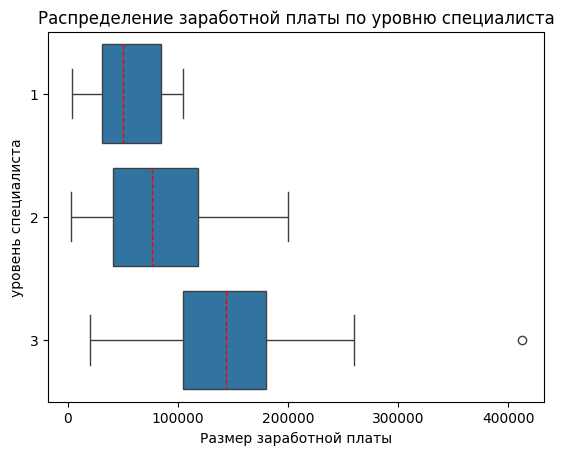

In [20]:
ax = sns.boxplot(df_copy, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработной платы', ylabel='уровень специалиста')
plt.title('Распределение заработной платы по уровню специалиста')
plt.show()

Здесь явно прослеживается закономерность - чем выше уровень специалиста, тем больше его заработная плата

### Соотношение зарплат Data Scientist и Data Engineer в 2022 году

In [30]:
jobs = ["^Data Scientist$", "^Data Engineer$"]
df_copy = hr_df[hr_df["job_title"].str.contains("|".join(jobs), regex=True)]
df_copy = df_copy[df_copy["work_year"] == 2022]


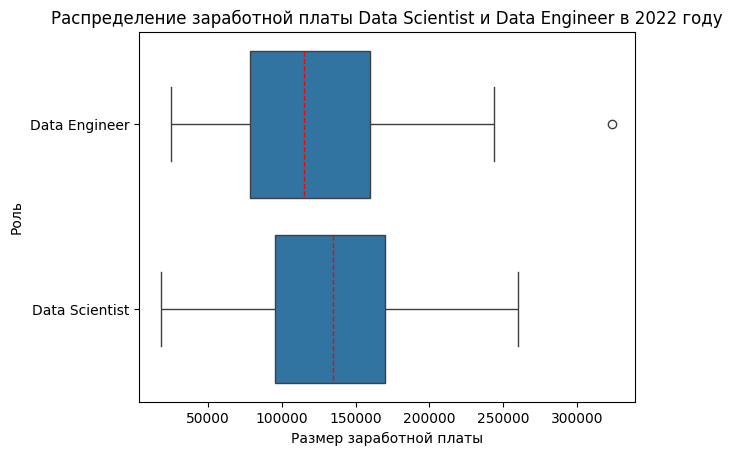

In [29]:
ax = sns.boxplot(df_copy, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработной платы', ylabel='Роль')
plt.title('Распределение заработной платы Data Scientist и Data Engineer в 2022 году')
plt.show()

Соотношение заработных плат примерно одинаково, но на графике видно что в целом оплата труда Data Scientist специалиста выше в 2022 году.

### Cоотношение зарплаты специалистов Data Scientist в компаниях различных размеров

In [31]:
df_copy = hr_df[hr_df["job_title"] == "Data Scientist"]

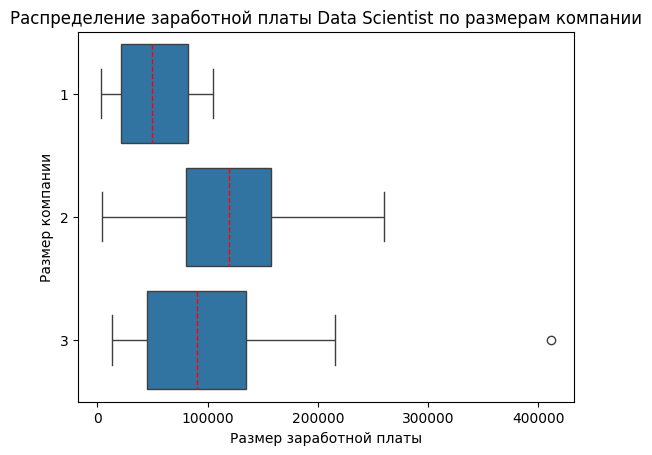

In [32]:
ax = sns.boxplot(df_copy, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработной платы', ylabel='Размер компании')
plt.title('Распределение заработной платы Data Scientist по размерам компании')
plt.show()

То есть распределение следующее:

$m_S$ - медианная оплата труда в маленьких компаниях \
$m_M$ - медианная оплата труда в средних компаниях \
$m_L$ - медианная оплата труда в больших компаниях

$m_S < m_L < m_M$

Делаем вывод что в средних компаниях самая большая оплата труда, а в маленьких самая низкая оплата труда

Так же можем сделать вывод, что зарплата в 400тыс. может не являться выбросом. \
Такую зарплату получил человек в 2020 году в крупной компании, работающий по специальности Data Engineer уровня Senior/Expert

### Есть ли связь между наличием должностей **Data Scientist** и **Data Engineer** и размером компании?

Для проведения данного анализа подготовим данные

In [39]:
jobs = ["^Data Scientist$", "^Data Engineer$"]
df_copy = hr_df[hr_df["job_title"].str.contains("|".join(jobs), regex=True)]
df_copy = df_copy[["job_title", "company_size"]]
df_copy.head()

,job_title,company_size
0,Data Scientist,3
7,Data Scientist,3
10,Data Scientist,1
11,Data Scientist,3
12,Data Scientist,2


Закодируем признаки и построим матрицу корреляции \
Для каждого признака будем использовать *One-Hot Encoding*

In [40]:
encoder = ce.OneHotEncoder(cols=['job_title'], use_cat_names=True)
type_bin = encoder.fit_transform(df_copy['job_title'])
df_copy = pd.concat([df_copy, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['company_size'], use_cat_names=True)
type_bin = encoder.fit_transform(df_copy['company_size'])
df_copy = pd.concat([df_copy, type_bin], axis=1)
df_copy = df_copy.drop(["job_title", "company_size"], axis=1)

df_copy.head()

,job_title_Data Scientist,job_title_Data Engineer,company_size_3.0,company_size_1.0,company_size_2.0
0,1,0,1,0,0
7,1,0,1,0,0
10,1,0,0,1,0
11,1,0,1,0,0
12,1,0,0,0,1


Построим матрицу корреляции

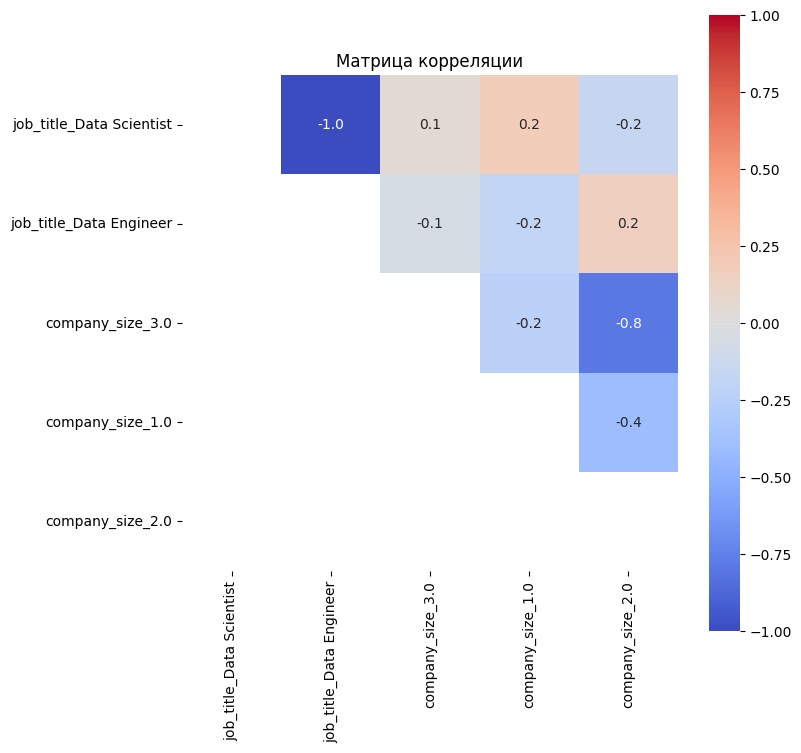

In [43]:
import numpy as np
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 8))
ax1.set_title("Матрица корреляции")

param = {
    "annot":True, 
    "fmt":".1f", 
    "vmin":-1, 
    "vmax":1, 
    "center":0, 
    "cmap":"coolwarm",
    "square":True
}
heat_mask = np.tril(df_copy.corr(numeric_only=True))
sns.heatmap(df_copy.corr(numeric_only=True), ax=ax1, **param, mask=heat_mask);

Как видим коэффициенты между должностью и размером компании в пределах $\pm$ 0.2, что говорит нам об очень слабой связи между признаками

## Статистическое тестирование

Зададим коэффициент принятия решения равным 0.05

In [44]:
alpha = 0.05

Для статистического тестирования подготовим пару функций:

In [53]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}.\nРаспределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}.\nРаспределение является нормальным'.format(alpha))
        

# функция для принятия решения о равенстве дисперсий
def decision_disper(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('Дисперсии не одинаковы.')
    else:
        print('Дисперсии одинаковы.')


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}.\nОтвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}.\nУ нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

### Построение гипотиз

1. Наблюдается ли ежегодный рост зарплат у специалистов **Data Scientist**?
    * Заработная плата Data Scientist специалиста за 2021 год увеличелась по сравнению с 2020?
    * Заработная плата Data Scientist специалиста за 2022 год увеличелась по сравнению с 2021?

2. Как соотносятся зарплаты **Data Scientist** и **Data Engineer** в 2022 году?
    * Заработная плата Data Scientist специалиста больше чем у Data Engineer в 2022 году?

3. Как соотносятся зарплаты специалистов **Data Scientist** в компаниях различных размеров?
    * Заработная плата Data Scientist специалиста в маленьких компаниях меньше чем в крупных?
    * Заработная плата Data Scientist специалиста в крупных компаниях меньше чем в средних?

4. Есть ли связь между наличием должностей **Data Scientist** и **Data Engineer** и размером компании?

___

#### Наблюдается ли ежегодный рост зарплат у специалистов **Data Scientist**?

* Заработная плата Data Scientist специалиста за 2021 год увеличелась по сравнению с 2020?

Нулевая гипотиза: за 2021 год зарплата не изменилась или уменьшилась по сравнению с 2020 \
Альтернативная: за 2021 год зарплата увеличилась по сравнению с 2020

$\mu_1$ - зарплата за 2020 год \
$\mu_2$ - зарплата за 2021 год

$H_0 : \mu_1 \geq \mu_2$ \
$H_1 : \mu_1 < \mu_2$

In [67]:
data_2020 = np.array(hr_df[(hr_df["job_title"] == "Data Scientist") & (hr_df["work_year"] == 2020)]["salary_in_usd"])
data_2021 = np.array(hr_df[(hr_df["job_title"] == "Data Scientist") & (hr_df["work_year"] == 2021)]["salary_in_usd"])
data_2022 = np.array(hr_df[(hr_df["job_title"] == "Data Scientist") & (hr_df["work_year"] == 2022)]["salary_in_usd"])

Проверим данные на нормальность используя тест Шапиро — Уилка

In [68]:
import scipy.stats as stats

_, p = stats.shapiro(data_2020)
decision_normality(p)
print()
_, p = stats.shapiro(data_2021)
decision_normality(p)
print()
_, p = stats.shapiro(data_2022)
decision_normality(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Распределение отлично от нормального

p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05.
Распределение является нормальным

p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05.
Распределение является нормальным


Подведем итоги и выберем метод тестирования:

* Тип признака - **количественный**
* Количество сравниваемых групп - **2**
* Признаки зависимы - **нет**
* распределены по нормальному закону - **нет**

Нам подходит U-Критерий Манна — Уитни \
Приступаем к тестированию:

In [75]:
_, p = stats.mannwhitneyu(data_2020, data_2021, alternative = 'less') # основной тест
decision_hypothesis(p)
print()
_, p = stats.mannwhitneyu(data_2020, data_2021, alternative="two-sided")
decision_hypothesis(p)

p-value = 0.705
p-значение больше, чем заданный уровень значимости 0.05.
У нас нет оснований отвергнуть нулевую гипотезу.

p-value = 0.599
p-значение больше, чем заданный уровень значимости 0.05.
У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:** у нас недостаточно оснований, чтобы утверждать, что зарплата за 2021 год выросла по сравнению с зарплатой за 2020 год для специалистов Data Scientist. С учетом второго теста можем сказать, что зарплата за 2021 год и за 2020 год примерно одинакова, что мы могли наблюдать на графиках выше

___

* Заработная плата Data Scientist специалиста за 2022 год увеличелась по сравнению с 2021?

Нулевая гипотиза: за 2022 год зарплата не изменилась или уменьшилась по сравнению с 2021 \
Альтернативная: за 2022 год зарплата увеличилась по сравнению с 2021

$\mu_1$ - зарплата за 2021 год \
$\mu_2$ - зарплата за 2022 год

$H_0 : \mu_1 \geq \mu_2$ \
$H_1 : \mu_1 < \mu_2$

Подведем итоги и выберем метод тестирования:

* Тип признака - **количественный**
* Количество сравниваемых групп - **2**
* Признаки зависимы - **нет**
* распределены по нормальному закону - **да**

Нам подходит Двухвыборочный t-критерий \
Приступаем к тестированию:

Проведем тест на равенство дисперсий

In [69]:
result = stats.levene(data_2021, data_2022)
p = result[1]
decision_disper(p)

p-value = 0.264
Дисперсии одинаковы.


In [70]:
_, p = stats.ttest_ind(data_2021, data_2022, alternative='less', equal_var=True)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** Зарплаты за 2022 год однозначно выросли по сравнению с 2021 годом для специалистов Data Scientist

**Общий вывод по вопросу:** Точно сделать заявление, что зарплаты с каждым годом растут мы не можем, но мы можем точно утверждать что начиная с 2022 года зарплаты выросли

___

#### Как соотносятся зарплаты **Data Scientist** и **Data Engineer** в 2022 году?

* Заработная плата Data Scientist специалиста больше чем у Data Engineer в 2022 году?

Нулевая гипотиза: Зарплаты Data Scientist специалистов меньше или равны зарплатам Data Engineer специалистов \
Альтернативная: Зарплаты Data Scientist специалистов больше зарплат Data Engineer специалистов

$\mu_1$ - зарплата за 2022 год Data Scientist специалистов \
$\mu_2$ - зарплата за 2022 год Data Engineer специалистов

$H_0 : \mu_1 \leq \mu_2$ \
$H_1 : \mu_1 > \mu_2$

In [71]:
data_scientist = np.array(hr_df[(hr_df["job_title"] == "Data Scientist") & (hr_df["work_year"] == 2022)]["salary_in_usd"])
data_engineer = np.array(hr_df[(hr_df["job_title"] == "Data Engineer") & (hr_df["work_year"] == 2022)]["salary_in_usd"])

Проверим данные на нормальность:

In [72]:
_, p = stats.shapiro(data_scientist)
decision_normality(p)
print()
_, p = stats.shapiro(data_engineer)
decision_normality(p)

p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05.
Распределение является нормальным

p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05.
Распределение отлично от нормального


Подведем итоги и выберем метод тестирования:

* Тип признака - **количественный**
* Количество сравниваемых групп - **2**
* Признаки зависимы - **нет**
* распределены по нормальному закону - **нет**

Нам подходит U-Критерий Манна — Уитни \
Приступаем к тестированию:

In [76]:
_, p = stats.mannwhitneyu(data_scientist, data_engineer, alternative="greater") # Основной тест
decision_hypothesis(p)
print()
_, p = stats.mannwhitneyu(data_scientist, data_engineer, alternative="less")
decision_hypothesis(p)
print()
_, p = stats.mannwhitneyu(data_scientist, data_engineer, alternative="two-sided")
decision_hypothesis(p)

p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05.
У нас нет оснований отвергнуть нулевую гипотезу.

p-value = 0.841
p-значение больше, чем заданный уровень значимости 0.05.
У нас нет оснований отвергнуть нулевую гипотезу.

p-value = 0.319
p-значение больше, чем заданный уровень значимости 0.05.
У нас нет оснований отвергнуть нулевую гипотезу.


**Общий вывод по вопросу:** Зарплаты специалистов Data Scientist и Data Engineer одинаковы за 2022 год.

___

#### Как соотносятся зарплаты специалистов **Data Scientist** в компаниях различных размеров?

* Есть ли разница по зарплатам в разных по размеру компаниях по специальности Data Scientist

In [78]:
mask_data_scientist = hr_df["job_title"] == "Data Scientist"
data_small = np.array(hr_df[mask_data_scientist & (hr_df["company_size"] == 1)]["salary_in_usd"])
data_medium = np.array(hr_df[mask_data_scientist & (hr_df["company_size"] == 2)]["salary_in_usd"])
data_large = np.array(hr_df[mask_data_scientist & (hr_df["company_size"] == 3)]["salary_in_usd"])

Протестируем данные на нормальность:

In [80]:
_, p = stats.shapiro(data_small)
decision_normality(p)
print()
_, p = stats.shapiro(data_medium)
decision_normality(p)
print()
_, p = stats.shapiro(data_large)
decision_normality(p)

p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05.
Распределение является нормальным

p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05.
Распределение является нормальным

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Распределение отлично от нормального


Гипотизы:

Нулевая: разницы нет \
Альтернативная: разница есть

$m_1$ - медианная зарплата в маленьких компаниях \
$m_2$ - медианная зарплата в средних компаниях \
$m_3$ - медианная зарплата в крупных компаниях

$H_0 : m_1 = m_2 = m_3$ \
$H_1 : m_1 \neq m_2 \neq m_3$

Подведем итоги и выберем метод тестирования:

* Тип признака - **количественный**
* Количество сравниваемых групп - **3**
* Признаки зависимы - **нет**
* распределены по нормальному закону - **нет**

Нам подходит тест Краскела - Уоллиса \
Приступаем к тестированию:

In [81]:
_, p = stats.kruskal(data_small, data_medium, data_large)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05.
Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** В зависимости от размера компании присутствует различие в размере оплаты труда специалистов Data Scientist

___

* Заработная плата Data Scientist специалиста в маленьких компаниях меньше чем в крупных?

Гипотезы:

Нулевая: Зарплата в маленьких компаниях больше или такая же как и в крупных \
Альтернативная: Зарплата в маленьких компаниях меньше чем в крупных

$m_S$ - медианная зарплата в маленьких компаниях \
$m_L$ - медианная зарплата в крупных компаниях

$H_0 : m_S \geq m_L$ \
$H_1 : m_S < m_L$

Подведем итоги и выберем метод тестирования:

* Тип признака - **количественный**
* Количество сравниваемых групп - **2**
* Признаки зависимы - **нет**
* распределены по нормальному закону - **нет**

Нам подходит U-критерий Манна — Уитни \
Приступаем к тестированию:

In [82]:
_, p = stats.mannwhitneyu(data_small, data_large, alternative="less")
decision_hypothesis(p)

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05.
Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** Зарплаты в курпных компаниях действительно больше чем в маленьких для специалистов Data Scientist

___

* Заработная плата Data Scientist специалиста в крупных компаниях меньше чем в средних?

Гипотезы:

Нулевая: Зарплата в крупных компаниях больше или такая же как и в средних \
Альтернативная: Зарплата в крупных компаниях меньше чем в средних

$m_M$ - медианная зарплата в средних компаниях \
$m_L$ - медианная зарплата в крупных компаниях

$H_0 : m_M \leq m_L$ \
$H_1 : m_M > m_L$

Подведем итоги и выберем метод тестирования:

* Тип признака - **количественный**
* Количество сравниваемых групп - **2**
* Признаки зависимы - **нет**
* распределены по нормальному закону - **нет**

Нам подходит U-критерий Манна — Уитни \
Приступаем к тестированию:

In [83]:
_, p = stats.mannwhitneyu(data_medium, data_large, alternative="greater")
decision_hypothesis(p)

p-value = 0.024
p-значение меньше, чем заданный уровень значимости 0.05.
Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** Зарплаты в курпных компаниях действительно меньше чем в средних для специалистов Data Scientist

**Общий вывод по вопросу:** Учитывая что наши распределения выстроились следующим образом: $(m_S < m_L)$ и $(m_L < m_M)$, мы можем утверждать что справедливо распределение: $(m_S < m_L < m_M)$ \
А значит специалисты Data Scientist больше всего зарабатывают в средних компаниях

___

#### Есть ли связь между наличием должностей **Data Scientist** и **Data Engineer** и размером компании?

Гипотезы:

Нулевая: связи нет \
Альтернативная: связь есть

Подведем итоги и выберем метод тестирования:

* Тип признака - **категориальный**
* Необходимо найти связь признаков - **да**

Нам подходит Критерий хи-квадрат ($\chi^2$) \
Приступаем к тестированию:

Построим кросс-таблицу распределения:

In [87]:
jobs = ["^Data Scientist$", "^Data Engineer$"]
data = hr_df[hr_df["job_title"].str.contains("|".join(jobs), regex=True)]
cross_table = pd.crosstab(data["job_title"], data["company_size"])
display(cross_table)

company_size,1,2,3
job_title,,,
Data Engineer,6,81,34
Data Scientist,21,66,43


In [88]:
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05.
Отвергаем нулевую гипотезу в пользу альтернативной.


**Общий вывод по вопросу:** В ходе тестирования было выяснено, что связь между специальностями Data Scientist, Data Engineer и размером компании четко прослеживается.